#This is the script for task 9 and 10.

#Notice:When you run the model first time, Colab always gives you the error: invalid literal for int() with base 10: 'max\n'.In order to resolve this error, go to the utils.py; then, you need to use docker_limit = int(f.read() with docker_limit = 5000000000000000
#the value of docker_limit must be very large. If its value is small, you will get the another error, the lack of memory error. After changing the value, go to Runtime and select restert and run all in order to run the model. After this process, my all codes succefully run.

#Another notice: I do not put random seed in my model (because I do not know how to specify the random seed in ray), if you re-run my codes, you may get a bit different result.However, to show my results exactly come from my codes, all the reults are described in this scrpit, Atari_project.ipynb.

#The last notice:my codes only work with GPU. Therefore, before running my code, please change the runtime type on google colab.To specify runtime type, go to the right upper side on the screen and click RAM Disk, and go to view resorces; then, choose GPU mode.

In [ ]:
# Install rllib to use DRL algorithm
!pip install -U "ray[rllib]" torch
# this is needed
!pip install GPUtil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Download and import Atari games.This is follows by https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_04_atari.ipynb

#In order for Atari environment to work on google colab. I choose "SpaceInvaders-v0"

In [ ]:
! wget http://www.atarimania.com/roms/Roms.rar
! mkdir /content/ROM/
! unrar e -o+ /content/Roms.rar /content/ROM/
! python -m atari_py.import_roms /content/ROM/

--2022-04-22 16:56:11--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19583716 (19M) [application/x-rar-compressed]
Saving to: ‘Roms.rar.1’

Roms.rar.1          100%[===================>]  18.68M  4.70MB/s    in 4.0s    

2022-04-22 16:56:15 (4.66 MB/s) - ‘Roms.rar.1’ saved [19583716/19583716]

mkdir: cannot create directory ‘/content/ROM/’: File exists

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Roms.rar

Extracting  /content/ROM/128 in 1 Game Select ROM (Unknown) ~.bin          0%  OK 
Extracting  /content/ROM/2 in 1 - Chess, Othello (Atari) (Prototype).bin       0%  OK 
Extracting  /content/ROM/2 Pak Special - Cavern Blaster, City War (1992) (HES) (773-867) (PAL).bin       0%  OK 
Extracting  /content/ROM/

# From here, I basically follow the lab 09 solution in our class. The website is as follows:https://moodle.city.ac.uk/course/view.php?id=41658

In [ ]:
import ray
import ray.rllib.agents.dqn as dqn

def evaluation_fn(result):
    return result['episode_reward_mean']


def objective_fn(config):
    rewards = []
    trainer = dqn.DQNTrainer(config=config)

    for i in range(20):
      # Perform one iteration of training the policy with DQN
      result = trainer.train()
      intermediate_score = evaluation_fn(result)
      rewards.append(result['episode_reward_mean'])
      # Feed the score back back to Tune.
      tune.report(iterations=i, mean_reward=intermediate_score)

      

# In the first time, I specify which version of DQN has the best performance and fix other important hyper parameters explicitly.

In [ ]:
import ray
import ray.rllib.agents.dqn as dqn
from ray.tune.logger import pretty_print
from ray import tune  

config = dqn.DEFAULT_CONFIG.copy()



#By tuning the improvements of DQN, I specify which DQN type algorithm outerperforms in my environment, Space Invader Game.
config["dueling"] = tune.grid_search([True, False])
config["double_q"] = tune.grid_search([True, False])
config['noisy']=tune.grid_search([True, False])
config['prioritized_replay']=tune.grid_search([True, False])
config['n_step']=tune.grid_search([1,5])


#They are explicityly fixed important hyper parameters. They will be tuned on the second hyper parameter tuning after specifiying the the of DQN algorhtim.
config["gamma"] = 0.7
config["train_batch_size"]= 32
config['timesteps_per_iteration']=1000
config['target_network_update_freq']=500
config['exploration_config'] =tune.grid_search([{'type': 'EpsilonGreedy', 'initial_epsilon': 1.0, 'final_epsilon': 0.02, 'epsilon_timesteps': 10000}])
config["model"] = { "fcnet_hiddens": [128, 128, 128],
                    "fcnet_activation": 'relu',
    }

#This is my choosen Atari environment, Space Invader
config["env"] = "SpaceInvaders-v0"

analysis = tune.run(
        objective_fn,
        metric="mean_reward",
        mode="max",
        num_samples=1,
        config=config)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print("Best hyperparameters found were: ", analysis.best_config)

Best hyperparameters found were:  {'num_workers': 0, 'num_envs_per_worker': 1, 'create_env_on_driver': False, 'rollout_fragment_length': 4, 'batch_mode': 'truncate_episodes', 'gamma': 0.7, 'lr': 0.0005, 'train_batch_size': 32, 'model': {'fcnet_hiddens': [128, 128, 128], 'fcnet_activation': 'relu'}, 'optimizer': {}, 'horizon': None, 'soft_horizon': False, 'no_done_at_end': False, 'env': 'SpaceInvaders-v0', 'observation_space': None, 'action_space': None, 'env_config': {}, 'remote_worker_envs': False, 'remote_env_batch_wait_ms': 0, 'env_task_fn': None, 'render_env': False, 'record_env': False, 'clip_rewards': None, 'normalize_actions': True, 'clip_actions': False, 'preprocessor_pref': 'deepmind', 'log_level': 'WARN', 'callbacks': <class 'ray.rllib.agents.callbacks.DefaultCallbacks'>, 'ignore_worker_failures': False, 'log_sys_usage': True, 'fake_sampler': False, 'framework': 'tf', 'eager_tracing': False, 'eager_max_retraces': 20, 'explore': True, 'exploration_config': {'type': 'EpsilonGre

In [ ]:
all_dataframes = analysis.trial_dataframes

all_dataframes

{"/root/ray_results/objective_fn_2022-04-22_16-56-26/objective_fn_SpaceInvaders-v0_2626f_00000_0_double_q=True,dueling=True,exploration_config={'type': 'EpsilonGreedy', 'initial_epsil_2022-04-22_16-56-27":     iterations  mean_reward  time_this_iter_s   done  timesteps_total  \
 0            0          NaN         14.266315  False              NaN   
 1            1   200.000000         37.194565  False              NaN   
 2            2   263.333333         45.885697  False              NaN   
 3            3   205.000000         48.371519  False              NaN   
 4            4   166.666667         49.738565  False              NaN   
 5            5   151.875000         48.037597  False              NaN   
 6            6   178.333333         50.903872  False              NaN   
 7            7   165.909091         50.416564  False              NaN   
 8            8   170.833333         48.248933  False              NaN   
 9            9   159.642857         51.725823  False  

In [ ]:
df = analysis.results_df

/usr/local/lib/python3.7/dist-packages/ray/tune/analysis/experiment_analysis.py:302: UserWarning: Dataframes will use '/' instead of '.' to delimit nested result keys in future versions of Ray. For forward compatibility, set the environment variable TUNE_RESULT_DELIM='/'
  "Dataframes will use '/' instead of '.' to delimit "


In [ ]:
df[['config.gamma', 'config.double_q', 'config.dueling', 'config.noisy', 'config.prioritized_replay', 'config.n_step', 'mean_reward']]




,config.gamma,config.double_q,config.dueling,config.noisy,config.prioritized_replay,config.n_step,mean_reward
trial_id,,,,,,,
2626f_00000,0.7,True,True,True,True,1,140.862069
2626f_00001,0.7,False,True,True,True,1,140.178571
2626f_00002,0.7,True,False,True,True,1,133.833333
2626f_00003,0.7,False,False,True,True,1,187.307692
2626f_00004,0.7,True,True,True,True,5,162.407407
2626f_00005,0.7,False,True,True,True,5,212.173913
2626f_00006,0.7,True,False,True,True,5,146.666667
2626f_00007,0.7,False,False,True,True,5,178.703704
2626f_00008,0.7,True,True,False,True,1,148.448276


In [ ]:
import matplotlib.pyplot as plt

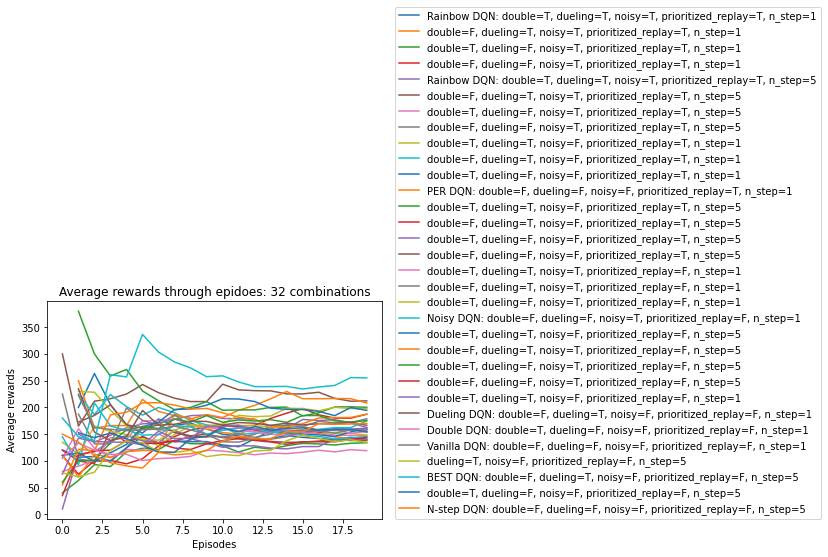

In [ ]:
# from 0 to 31, 32 combinations!! [0] - [31]
plt.plot(list(all_dataframes.values())[0]['mean_reward'], label= 'Rainbow DQN: double=T, dueling=T, noisy=T, prioritized_replay=T, n_step=1')
plt.plot(list(all_dataframes.values())[1]['mean_reward'], label= 'double=F, dueling=T, noisy=T, prioritized_replay=T, n_step=1')
plt.plot(list(all_dataframes.values())[2]['mean_reward'], label= 'double=T, dueling=F, noisy=T, prioritized_replay=T, n_step=1')
plt.plot(list(all_dataframes.values())[3]['mean_reward'], label= 'double=F, dueling=F, noisy=T, prioritized_replay=T, n_step=1')

plt.plot(list(all_dataframes.values())[4]['mean_reward'], label= 'Rainbow DQN: double=T, dueling=T, noisy=T, prioritized_replay=T, n_step=5')
plt.plot(list(all_dataframes.values())[5]['mean_reward'], label= 'double=F, dueling=T, noisy=T, prioritized_replay=T, n_step=5')
plt.plot(list(all_dataframes.values())[6]['mean_reward'], label= 'double=T, dueling=F, noisy=T, prioritized_replay=T, n_step=5')
plt.plot(list(all_dataframes.values())[7]['mean_reward'], label= 'double=F, dueling=F, noisy=T, prioritized_replay=T, n_step=5')

plt.plot(list(all_dataframes.values())[8]['mean_reward'], label= 'double=T, dueling=T, noisy=F, prioritized_replay=T, n_step=1')
plt.plot(list(all_dataframes.values())[9]['mean_reward'], label= 'double=F, dueling=T, noisy=F, prioritized_replay=T, n_step=1')
plt.plot(list(all_dataframes.values())[10]['mean_reward'], label= 'double=T, dueling=F, noisy=F, prioritized_replay=T, n_step=1')
plt.plot(list(all_dataframes.values())[11]['mean_reward'], label= 'PER DQN: double=F, dueling=F, noisy=F, prioritized_replay=T, n_step=1')

plt.plot(list(all_dataframes.values())[12]['mean_reward'], label= 'double=T, dueling=T, noisy=F, prioritized_replay=T, n_step=5')
plt.plot(list(all_dataframes.values())[13]['mean_reward'], label= 'double=F, dueling=T, noisy=F, prioritized_replay=T, n_step=5')
plt.plot(list(all_dataframes.values())[14]['mean_reward'], label= 'double=T, dueling=F, noisy=F, prioritized_replay=T, n_step=5')
plt.plot(list(all_dataframes.values())[15]['mean_reward'], label= 'double=F, dueling=F, noisy=F, prioritized_replay=T, n_step=5')

plt.plot(list(all_dataframes.values())[16]['mean_reward'], label= 'double=T, dueling=T, noisy=T, prioritized_replay=F, n_step=1')
plt.plot(list(all_dataframes.values())[17]['mean_reward'], label= 'double=F, dueling=T, noisy=T, prioritized_replay=F, n_step=1')
plt.plot(list(all_dataframes.values())[18]['mean_reward'], label= 'double=T, dueling=F, noisy=T, prioritized_replay=F, n_step=1')
plt.plot(list(all_dataframes.values())[19]['mean_reward'], label= 'Noisy DQN: double=F, dueling=F, noisy=T, prioritized_replay=F, n_step=1')

plt.plot(list(all_dataframes.values())[20]['mean_reward'], label= 'double=T, dueling=T, noisy=F, prioritized_replay=F, n_step=5')
plt.plot(list(all_dataframes.values())[21]['mean_reward'], label= 'double=F, dueling=T, noisy=T, prioritized_replay=F, n_step=5')
plt.plot(list(all_dataframes.values())[22]['mean_reward'], label= 'double=T, dueling=F, noisy=T, prioritized_replay=F, n_step=5')
plt.plot(list(all_dataframes.values())[23]['mean_reward'], label= 'double=F, dueling=F, noisy=T, prioritized_replay=F, n_step=5')

plt.plot(list(all_dataframes.values())[24]['mean_reward'], label= 'double=T, dueling=T, noisy=F, prioritized_replay=F, n_step=1')
plt.plot(list(all_dataframes.values())[25]['mean_reward'], label= 'Dueling DQN: double=F, dueling=T, noisy=F, prioritized_replay=F, n_step=1')
plt.plot(list(all_dataframes.values())[26]['mean_reward'], label= 'Double DQN: double=T, dueling=F, noisy=F, prioritized_replay=F, n_step=1')
plt.plot(list(all_dataframes.values())[27]['mean_reward'], label= 'Vanilla DQN: double=F, dueling=F, noisy=F, prioritized_replay=F, n_step=1')

plt.plot(list(all_dataframes.values())[28]['mean_reward'], label= 'dueling=T, noisy=F, prioritized_replay=F, n_step=5')
plt.plot(list(all_dataframes.values())[29]['mean_reward'], label= 'BEST DQN: double=F, dueling=T, noisy=F, prioritized_replay=F, n_step=5')
plt.plot(list(all_dataframes.values())[30]['mean_reward'], label= 'double=T, dueling=F, noisy=F, prioritized_replay=F, n_step=5')
plt.plot(list(all_dataframes.values())[31]['mean_reward'], label= 'N-step DQN: double=F, dueling=F, noisy=F, prioritized_replay=F, n_step=5')

plt.legend(loc=(1.04,0))
plt.title('Average rewards through epidoes: 32 combinations')
plt.xlabel('Episodes')
plt.ylabel('Average rewards')
plt.show()

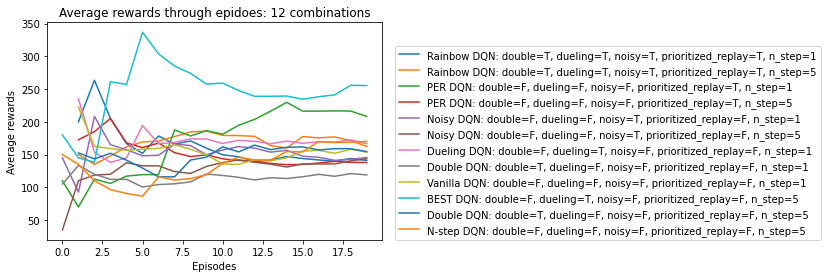

In [ ]:
plt.plot(list(all_dataframes.values())[0]['mean_reward'], label= 'Rainbow DQN: double=T, dueling=T, noisy=T, prioritized_replay=T, n_step=1')
plt.plot(list(all_dataframes.values())[4]['mean_reward'], label= 'Rainbow DQN: double=T, dueling=T, noisy=T, prioritized_replay=T, n_step=5')
plt.plot(list(all_dataframes.values())[11]['mean_reward'], label= 'PER DQN: double=F, dueling=F, noisy=F, prioritized_replay=T, n_step=1')
plt.plot(list(all_dataframes.values())[15]['mean_reward'], label= 'PER DQN: double=F, dueling=F, noisy=F, prioritized_replay=T, n_step=5')
plt.plot(list(all_dataframes.values())[19]['mean_reward'], label= 'Noisy DQN: double=F, dueling=F, noisy=T, prioritized_replay=F, n_step=1')
plt.plot(list(all_dataframes.values())[23]['mean_reward'], label= 'Noisy DQN: double=F, dueling=F, noisy=T, prioritized_replay=F, n_step=5')
plt.plot(list(all_dataframes.values())[25]['mean_reward'], label= 'Dueling DQN: double=F, dueling=T, noisy=F, prioritized_replay=F, n_step=1')
plt.plot(list(all_dataframes.values())[26]['mean_reward'], label= 'Double DQN: double=T, dueling=F, noisy=F, prioritized_replay=F, n_step=1')
plt.plot(list(all_dataframes.values())[27]['mean_reward'], label= 'Vanilla DQN: double=F, dueling=F, noisy=F, prioritized_replay=F, n_step=1')
plt.plot(list(all_dataframes.values())[29]['mean_reward'], label= 'BEST DQN: double=F, dueling=T, noisy=F, prioritized_replay=F, n_step=5')
plt.plot(list(all_dataframes.values())[30]['mean_reward'], label= 'Double DQN: double=T, dueling=F, noisy=F, prioritized_replay=F, n_step=5')
plt.plot(list(all_dataframes.values())[31]['mean_reward'], label= 'N-step DQN: double=F, dueling=F, noisy=F, prioritized_replay=F, n_step=5')

plt.legend(loc=(1.04,0))
plt.title('Average rewards through epidoes: 12 combinations')
plt.xlabel('Episodes')
plt.ylabel('Average rewards')
plt.show()

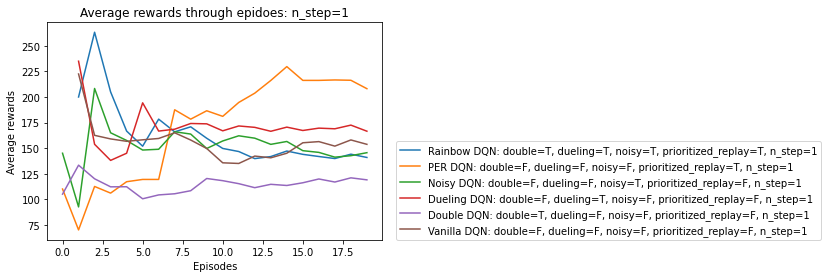

In [ ]:
plt.plot(list(all_dataframes.values())[0]['mean_reward'], label= 'Rainbow DQN: double=T, dueling=T, noisy=T, prioritized_replay=T, n_step=1')

plt.plot(list(all_dataframes.values())[11]['mean_reward'], label= 'PER DQN: double=F, dueling=F, noisy=F, prioritized_replay=T, n_step=1')

plt.plot(list(all_dataframes.values())[19]['mean_reward'], label= 'Noisy DQN: double=F, dueling=F, noisy=T, prioritized_replay=F, n_step=1')

plt.plot(list(all_dataframes.values())[25]['mean_reward'], label= 'Dueling DQN: double=F, dueling=T, noisy=F, prioritized_replay=F, n_step=1')
plt.plot(list(all_dataframes.values())[26]['mean_reward'], label= 'Double DQN: double=T, dueling=F, noisy=F, prioritized_replay=F, n_step=1')
plt.plot(list(all_dataframes.values())[27]['mean_reward'], label= 'Vanilla DQN: double=F, dueling=F, noisy=F, prioritized_replay=F, n_step=1')


plt.legend(loc=(1.04,0))
plt.title('Average rewards through epidoes: n_step=1')
plt.xlabel('Episodes')
plt.ylabel('Average rewards')
plt.show()

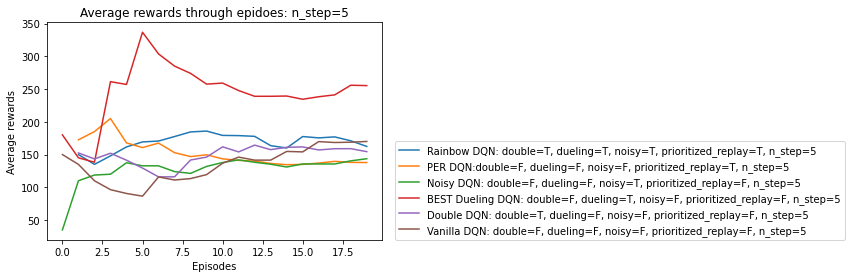

In [ ]:
plt.plot(list(all_dataframes.values())[4]['mean_reward'], label= 'Rainbow DQN: double=T, dueling=T, noisy=T, prioritized_replay=T, n_step=5')
plt.plot(list(all_dataframes.values())[15]['mean_reward'], label= 'PER DQN:double=F, dueling=F, noisy=F, prioritized_replay=T, n_step=5')
plt.plot(list(all_dataframes.values())[23]['mean_reward'], label= 'Noisy DQN: double=F, dueling=F, noisy=T, prioritized_replay=F, n_step=5')
plt.plot(list(all_dataframes.values())[29]['mean_reward'], label= 'BEST Dueling DQN: double=F, dueling=T, noisy=F, prioritized_replay=F, n_step=5')
plt.plot(list(all_dataframes.values())[30]['mean_reward'], label= 'Double DQN: double=T, dueling=F, noisy=F, prioritized_replay=F, n_step=5')
plt.plot(list(all_dataframes.values())[31]['mean_reward'], label= 'Vanilla DQN: double=F, dueling=F, noisy=F, prioritized_replay=F, n_step=5')

plt.legend(loc=(1.04,0))
plt.title('Average rewards through epidoes: n_step=5')
plt.xlabel('Episodes')
plt.ylabel('Average rewards')
plt.show()

#nosisy F, dueling T, doule F, n_step 5, prioritized F
#with this setting, from now on, I am going to explore the 2nd hyper parameters !

In [ ]:
import ray
import ray.rllib.agents.dqn as dqn

def evaluation_fn(result):
    return result['episode_reward_mean']


def objective_fn(config):
    rewards = []
    trainer = dqn.DQNTrainer(config=config)

    for i in range(20):
      # Perform one iteration of training the policy with DQN
      result = trainer.train()
      intermediate_score = evaluation_fn(result)
      rewards.append(result['episode_reward_mean'])
      # Feed the score back back to Tune.
      tune.report(iterations=i, mean_reward=intermediate_score)

In [ ]:
import ray
import ray.rllib.agents.dqn as dqn
from ray.tune.logger import pretty_print
from ray import tune  

config = dqn.DEFAULT_CONFIG.copy()



#These parameters are specified by the first hyper parameter tuning. Thus, a model type, meaning that
#which improvments (such as dueling) should be done for SpaceInvader Game for the agent to find the optimal policy so that it maximized its cummulative reward.
config["dueling"] = True
config["double_q"] = False
config['noisy']=False
config['prioritized_replay']= False
config['n_step']=5


#They are explicityly fixed important hyper parameters. Now explore different important parameters.
config["gamma"] = tune.grid_search([0.2, 0.8])
config["train_batch_size"]= tune.grid_search([32, 64])
config['timesteps_per_iteration']=tune.grid_search([500, 1000])
config['target_network_update_freq']=tune.grid_search([250, 500])


#only the model and policy configuations are kept.
config["model"] = { "fcnet_hiddens": [128, 128, 128],
                    "fcnet_activation": 'relu',
    }

#if i Change another policy, I got the error, and so I decided to keep using same epsilon greegy policy
config['exploration_config'] ={'type': 'EpsilonGreedy', 'initial_epsilon': 1.0, 'final_epsilon': 0.02, 'epsilon_timesteps': 10000}

#This is my choosen Atari environment, Space Invader
config["env"] = "SpaceInvaders-v0"

analysis = tune.run(
        objective_fn,
        metric="mean_reward",
        mode="max",
        num_samples=1,
        config=config)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
all_dataframes2 = analysis.trial_dataframes

all_dataframes2

{'/root/ray_results/objective_fn_2022-04-22_20-31-39/objective_fn_SpaceInvaders-v0_366c5_00000_0_gamma=0.2,target_network_update_freq=250,timesteps_per_iteration=500,train_batch_size=_2022-04-22_20-31-40':     iterations  mean_reward  time_this_iter_s   done  timesteps_total  \
 0            0   135.000000          8.938509  False              NaN   
 1            1   135.000000          8.418450  False              NaN   
 2            2   205.000000         11.461174  False              NaN   
 3            3   213.333333         16.731555  False              NaN   
 4            4   213.333333         17.197627  False              NaN   
 5            5   193.750000         17.850173  False              NaN   
 6            6   180.000000         17.878601  False              NaN   
 7            7   180.833333         17.815697  False              NaN   
 8            8   180.833333         19.042115  False              NaN   
 9            9   183.571429         18.653308  False  

In [ ]:
print("Best hyperparameters found were: ", analysis.best_config)

Best hyperparameters found were:  {'num_workers': 0, 'num_envs_per_worker': 1, 'create_env_on_driver': False, 'rollout_fragment_length': 4, 'batch_mode': 'truncate_episodes', 'gamma': 0.8, 'lr': 0.0005, 'train_batch_size': 64, 'model': {'fcnet_hiddens': [128, 128, 128], 'fcnet_activation': 'relu'}, 'optimizer': {}, 'horizon': None, 'soft_horizon': False, 'no_done_at_end': False, 'env': 'SpaceInvaders-v0', 'observation_space': None, 'action_space': None, 'env_config': {}, 'remote_worker_envs': False, 'remote_env_batch_wait_ms': 0, 'env_task_fn': None, 'render_env': False, 'record_env': False, 'clip_rewards': None, 'normalize_actions': True, 'clip_actions': False, 'preprocessor_pref': 'deepmind', 'log_level': 'WARN', 'callbacks': <class 'ray.rllib.agents.callbacks.DefaultCallbacks'>, 'ignore_worker_failures': False, 'log_sys_usage': True, 'fake_sampler': False, 'framework': 'tf', 'eager_tracing': False, 'eager_max_retraces': 20, 'explore': True, 'exploration_config': {'type': 'EpsilonGre

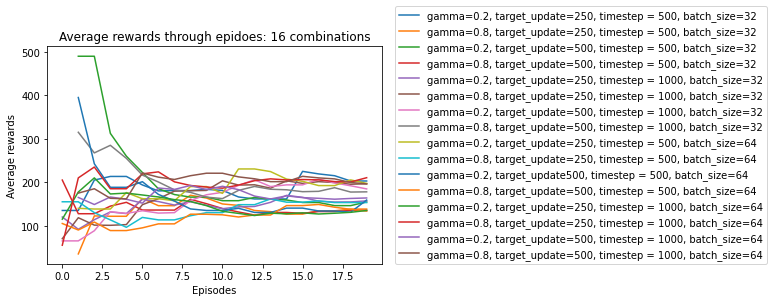

In [ ]:
# from 0 to 15 combinations!! [0] - [15]
plt.plot(list(all_dataframes2.values())[0]['mean_reward'], label= 'gamma=0.2, target_update=250, timestep = 500, batch_size=32')
plt.plot(list(all_dataframes2.values())[1]['mean_reward'], label= 'gamma=0.8, target_update=250, timestep = 500, batch_size=32')

plt.plot(list(all_dataframes2.values())[2]['mean_reward'], label= 'gamma=0.2, target_update=500, timestep = 500, batch_size=32')
plt.plot(list(all_dataframes2.values())[3]['mean_reward'], label= 'gamma=0.8, target_update=500, timestep = 500, batch_size=32')

plt.plot(list(all_dataframes2.values())[4]['mean_reward'], label= 'gamma=0.2, target_update=250, timestep = 1000, batch_size=32')
plt.plot(list(all_dataframes2.values())[5]['mean_reward'], label= 'gamma=0.8, target_update=250, timestep = 1000, batch_size=32')

plt.plot(list(all_dataframes2.values())[6]['mean_reward'], label= 'gamma=0.2, target_update=500, timestep = 1000, batch_size=32')
plt.plot(list(all_dataframes2.values())[7]['mean_reward'], label= 'gamma=0.8, target_update=500, timestep = 1000, batch_size=32')

plt.plot(list(all_dataframes2.values())[8]['mean_reward'], label= 'gamma=0.2, target_update=250, timestep = 500, batch_size=64')
plt.plot(list(all_dataframes2.values())[9]['mean_reward'], label= 'gamma=0.8, target_update=250, timestep = 500, batch_size=64')

plt.plot(list(all_dataframes2.values())[10]['mean_reward'], label= 'gamma=0.2, target_update500, timestep = 500, batch_size=64')
plt.plot(list(all_dataframes2.values())[11]['mean_reward'], label= 'gamma=0.8, target_update=500, timestep = 500, batch_size=64')

plt.plot(list(all_dataframes2.values())[12]['mean_reward'], label= 'gamma=0.2, target_update=250, timestep = 1000, batch_size=64')
plt.plot(list(all_dataframes2.values())[13]['mean_reward'], label= 'gamma=0.8, target_update=250, timestep = 1000, batch_size=64')

plt.plot(list(all_dataframes2.values())[14]['mean_reward'], label= 'gamma=0.2, target_update=500, timestep = 1000, batch_size=64')
plt.plot(list(all_dataframes2.values())[15]['mean_reward'], label= 'gamma=0.8, target_update=500, timestep = 1000, batch_size=64')

plt.legend(loc=(1.04,0))
plt.title('Average rewards through epidoes: 16 combinations')
plt.xlabel('Episodes')
plt.ylabel('Average rewards')
plt.show()

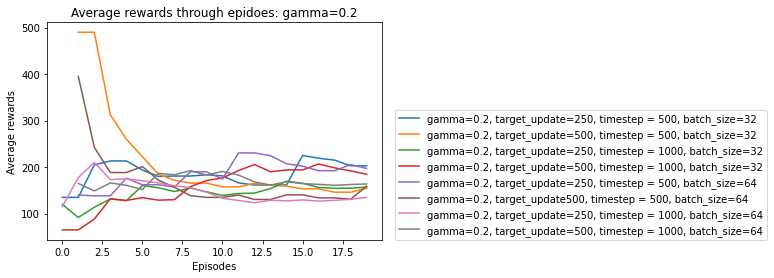

In [ ]:
plt.plot(list(all_dataframes2.values())[0]['mean_reward'], label= 'gamma=0.2, target_update=250, timestep = 500, batch_size=32')
plt.plot(list(all_dataframes2.values())[2]['mean_reward'], label= 'gamma=0.2, target_update=500, timestep = 500, batch_size=32')
plt.plot(list(all_dataframes2.values())[4]['mean_reward'], label= 'gamma=0.2, target_update=250, timestep = 1000, batch_size=32')
plt.plot(list(all_dataframes2.values())[6]['mean_reward'], label= 'gamma=0.2, target_update=500, timestep = 1000, batch_size=32')
plt.plot(list(all_dataframes2.values())[8]['mean_reward'], label= 'gamma=0.2, target_update=250, timestep = 500, batch_size=64')
plt.plot(list(all_dataframes2.values())[10]['mean_reward'], label= 'gamma=0.2, target_update500, timestep = 500, batch_size=64')
plt.plot(list(all_dataframes2.values())[12]['mean_reward'], label= 'gamma=0.2, target_update=250, timestep = 1000, batch_size=64')
plt.plot(list(all_dataframes2.values())[14]['mean_reward'], label= 'gamma=0.2, target_update=500, timestep = 1000, batch_size=64')

plt.legend(loc=(1.04,0))
plt.title('Average rewards through epidoes: gamma=0.2')
plt.xlabel('Episodes')
plt.ylabel('Average rewards')
plt.show()

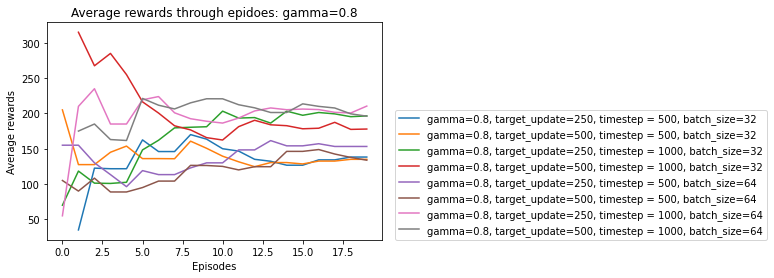

In [ ]:
plt.plot(list(all_dataframes2.values())[1]['mean_reward'], label= 'gamma=0.8, target_update=250, timestep = 500, batch_size=32')
plt.plot(list(all_dataframes2.values())[3]['mean_reward'], label= 'gamma=0.8, target_update=500, timestep = 500, batch_size=32')
plt.plot(list(all_dataframes2.values())[5]['mean_reward'], label= 'gamma=0.8, target_update=250, timestep = 1000, batch_size=32')
plt.plot(list(all_dataframes2.values())[7]['mean_reward'], label= 'gamma=0.8, target_update=500, timestep = 1000, batch_size=32')
plt.plot(list(all_dataframes2.values())[9]['mean_reward'], label= 'gamma=0.8, target_update=250, timestep = 500, batch_size=64')
plt.plot(list(all_dataframes2.values())[11]['mean_reward'], label= 'gamma=0.8, target_update=500, timestep = 500, batch_size=64')
plt.plot(list(all_dataframes2.values())[13]['mean_reward'], label= 'gamma=0.8, target_update=250, timestep = 1000, batch_size=64')
plt.plot(list(all_dataframes2.values())[15]['mean_reward'], label= 'gamma=0.8, target_update=500, timestep = 1000, batch_size=64')

plt.legend(loc=(1.04,0))
plt.title('Average rewards through epidoes: gamma=0.8')
plt.xlabel('Episodes')
plt.ylabel('Average rewards')
plt.show()

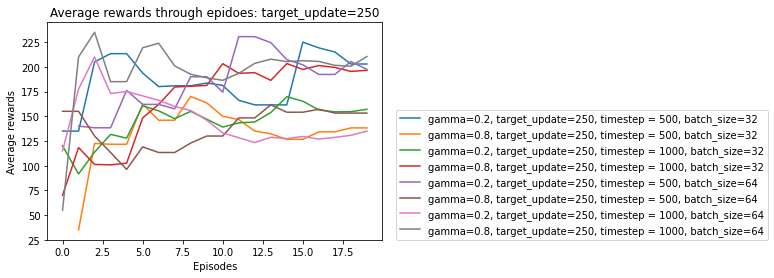

In [ ]:
plt.plot(list(all_dataframes2.values())[0]['mean_reward'], label= 'gamma=0.2, target_update=250, timestep = 500, batch_size=32')
plt.plot(list(all_dataframes2.values())[1]['mean_reward'], label= 'gamma=0.8, target_update=250, timestep = 500, batch_size=32')

plt.plot(list(all_dataframes2.values())[4]['mean_reward'], label= 'gamma=0.2, target_update=250, timestep = 1000, batch_size=32')
plt.plot(list(all_dataframes2.values())[5]['mean_reward'], label= 'gamma=0.8, target_update=250, timestep = 1000, batch_size=32')

plt.plot(list(all_dataframes2.values())[8]['mean_reward'], label= 'gamma=0.2, target_update=250, timestep = 500, batch_size=64')
plt.plot(list(all_dataframes2.values())[9]['mean_reward'], label= 'gamma=0.8, target_update=250, timestep = 500, batch_size=64')

plt.plot(list(all_dataframes2.values())[12]['mean_reward'], label= 'gamma=0.2, target_update=250, timestep = 1000, batch_size=64')
plt.plot(list(all_dataframes2.values())[13]['mean_reward'], label= 'gamma=0.8, target_update=250, timestep = 1000, batch_size=64')

plt.legend(loc=(1.04,0))
plt.title('Average rewards through epidoes: target_update=250')
plt.xlabel('Episodes')
plt.ylabel('Average rewards')
plt.show()

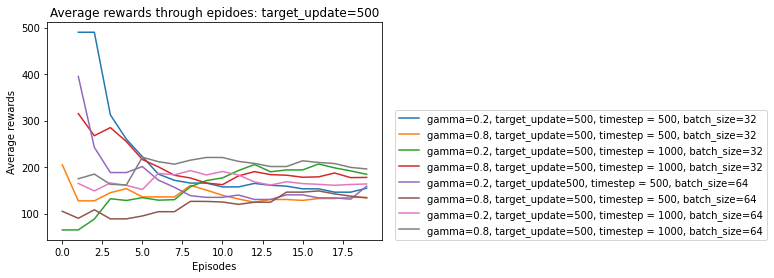

In [ ]:
plt.plot(list(all_dataframes2.values())[2]['mean_reward'], label= 'gamma=0.2, target_update=500, timestep = 500, batch_size=32')
plt.plot(list(all_dataframes2.values())[3]['mean_reward'], label= 'gamma=0.8, target_update=500, timestep = 500, batch_size=32')



plt.plot(list(all_dataframes2.values())[6]['mean_reward'], label= 'gamma=0.2, target_update=500, timestep = 1000, batch_size=32')
plt.plot(list(all_dataframes2.values())[7]['mean_reward'], label= 'gamma=0.8, target_update=500, timestep = 1000, batch_size=32')



plt.plot(list(all_dataframes2.values())[10]['mean_reward'], label= 'gamma=0.2, target_update500, timestep = 500, batch_size=64')
plt.plot(list(all_dataframes2.values())[11]['mean_reward'], label= 'gamma=0.8, target_update=500, timestep = 500, batch_size=64')


plt.plot(list(all_dataframes2.values())[14]['mean_reward'], label= 'gamma=0.2, target_update=500, timestep = 1000, batch_size=64')
plt.plot(list(all_dataframes2.values())[15]['mean_reward'], label= 'gamma=0.8, target_update=500, timestep = 1000, batch_size=64')

plt.legend(loc=(1.04,0))
plt.title('Average rewards through epidoes: target_update=500')
plt.xlabel('Episodes')
plt.ylabel('Average rewards')
plt.show()

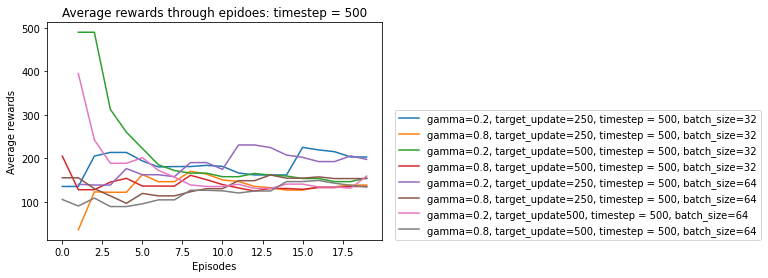

In [ ]:
plt.plot(list(all_dataframes2.values())[0]['mean_reward'], label= 'gamma=0.2, target_update=250, timestep = 500, batch_size=32')
plt.plot(list(all_dataframes2.values())[1]['mean_reward'], label= 'gamma=0.8, target_update=250, timestep = 500, batch_size=32')

plt.plot(list(all_dataframes2.values())[2]['mean_reward'], label= 'gamma=0.2, target_update=500, timestep = 500, batch_size=32')
plt.plot(list(all_dataframes2.values())[3]['mean_reward'], label= 'gamma=0.8, target_update=500, timestep = 500, batch_size=32')

plt.plot(list(all_dataframes2.values())[8]['mean_reward'], label= 'gamma=0.2, target_update=250, timestep = 500, batch_size=64')
plt.plot(list(all_dataframes2.values())[9]['mean_reward'], label= 'gamma=0.8, target_update=250, timestep = 500, batch_size=64')

plt.plot(list(all_dataframes2.values())[10]['mean_reward'], label= 'gamma=0.2, target_update500, timestep = 500, batch_size=64')
plt.plot(list(all_dataframes2.values())[11]['mean_reward'], label= 'gamma=0.8, target_update=500, timestep = 500, batch_size=64')

plt.legend(loc=(1.04,0))
plt.title('Average rewards through epidoes: timestep = 500')
plt.xlabel('Episodes')
plt.ylabel('Average rewards')
plt.show()

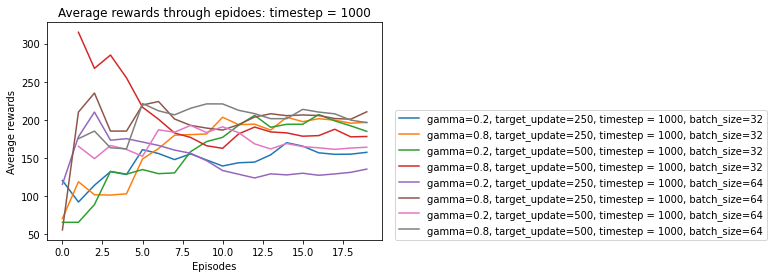

In [ ]:
plt.plot(list(all_dataframes2.values())[4]['mean_reward'], label= 'gamma=0.2, target_update=250, timestep = 1000, batch_size=32')
plt.plot(list(all_dataframes2.values())[5]['mean_reward'], label= 'gamma=0.8, target_update=250, timestep = 1000, batch_size=32')

plt.plot(list(all_dataframes2.values())[6]['mean_reward'], label= 'gamma=0.2, target_update=500, timestep = 1000, batch_size=32')
plt.plot(list(all_dataframes2.values())[7]['mean_reward'], label= 'gamma=0.8, target_update=500, timestep = 1000, batch_size=32')

plt.plot(list(all_dataframes2.values())[12]['mean_reward'], label= 'gamma=0.2, target_update=250, timestep = 1000, batch_size=64')
plt.plot(list(all_dataframes2.values())[13]['mean_reward'], label= 'gamma=0.8, target_update=250, timestep = 1000, batch_size=64')

plt.plot(list(all_dataframes2.values())[14]['mean_reward'], label= 'gamma=0.2, target_update=500, timestep = 1000, batch_size=64')
plt.plot(list(all_dataframes2.values())[15]['mean_reward'], label= 'gamma=0.8, target_update=500, timestep = 1000, batch_size=64')

plt.legend(loc=(1.04,0))
plt.title('Average rewards through epidoes: timestep = 1000')
plt.xlabel('Episodes')
plt.ylabel('Average rewards')
plt.show()

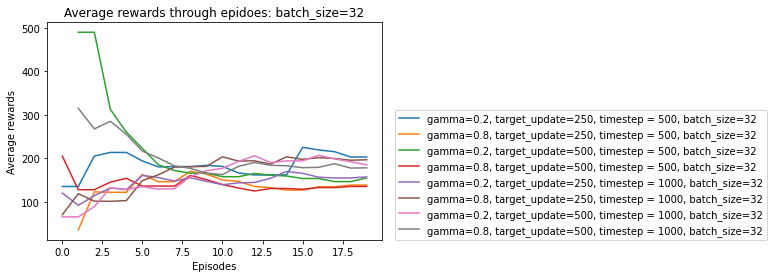

In [ ]:
plt.plot(list(all_dataframes2.values())[0]['mean_reward'], label= 'gamma=0.2, target_update=250, timestep = 500, batch_size=32')
plt.plot(list(all_dataframes2.values())[1]['mean_reward'], label= 'gamma=0.8, target_update=250, timestep = 500, batch_size=32')

plt.plot(list(all_dataframes2.values())[2]['mean_reward'], label= 'gamma=0.2, target_update=500, timestep = 500, batch_size=32')
plt.plot(list(all_dataframes2.values())[3]['mean_reward'], label= 'gamma=0.8, target_update=500, timestep = 500, batch_size=32')

plt.plot(list(all_dataframes2.values())[4]['mean_reward'], label= 'gamma=0.2, target_update=250, timestep = 1000, batch_size=32')
plt.plot(list(all_dataframes2.values())[5]['mean_reward'], label= 'gamma=0.8, target_update=250, timestep = 1000, batch_size=32')

plt.plot(list(all_dataframes2.values())[6]['mean_reward'], label= 'gamma=0.2, target_update=500, timestep = 1000, batch_size=32')
plt.plot(list(all_dataframes2.values())[7]['mean_reward'], label= 'gamma=0.8, target_update=500, timestep = 1000, batch_size=32')

plt.legend(loc=(1.04,0))
plt.title('Average rewards through epidoes: batch_size=32')
plt.xlabel('Episodes')
plt.ylabel('Average rewards')
plt.show()

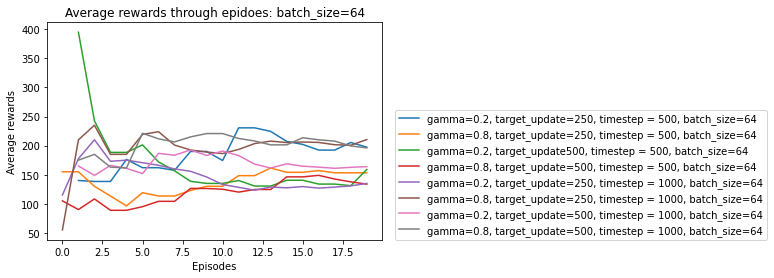

In [ ]:
plt.plot(list(all_dataframes2.values())[8]['mean_reward'], label= 'gamma=0.2, target_update=250, timestep = 500, batch_size=64')
plt.plot(list(all_dataframes2.values())[9]['mean_reward'], label= 'gamma=0.8, target_update=250, timestep = 500, batch_size=64')

plt.plot(list(all_dataframes2.values())[10]['mean_reward'], label= 'gamma=0.2, target_update500, timestep = 500, batch_size=64')
plt.plot(list(all_dataframes2.values())[11]['mean_reward'], label= 'gamma=0.8, target_update=500, timestep = 500, batch_size=64')

plt.plot(list(all_dataframes2.values())[12]['mean_reward'], label= 'gamma=0.2, target_update=250, timestep = 1000, batch_size=64')
plt.plot(list(all_dataframes2.values())[13]['mean_reward'], label= 'gamma=0.8, target_update=250, timestep = 1000, batch_size=64')

plt.plot(list(all_dataframes2.values())[14]['mean_reward'], label= 'gamma=0.2, target_update=500, timestep = 1000, batch_size=64')
plt.plot(list(all_dataframes2.values())[15]['mean_reward'], label= 'gamma=0.8, target_update=500, timestep = 1000, batch_size=64')

plt.legend(loc=(1.04,0))
plt.title('Average rewards through epidoes: batch_size=64')
plt.xlabel('Episodes')
plt.ylabel('Average rewards')
plt.show()

#The best model performance with the longer period. Check whether it will converge or not.
#I follow the code from lab 07 in this lecture for this convergence task: https://moodle.city.ac.uk/course/view.php?id=41658

In [ ]:
import ray
import ray.rllib.agents.dqn as dqn
from ray.tune.logger import pretty_print

config = dqn.DEFAULT_CONFIG.copy()

config['num_workers'] =0
config['num_envs_per_worker'] =1
config['create_env_on_driver'] =False
config['rollout_fragment_length'] = 4
config['batch_mode'] = 'truncate_episodes'
config['gamma'] = 0.8
config['lr'] = 0.0005
config['train_batch_size'] = 64
config['model'] = {'fcnet_hiddens': [128, 128, 128], 'fcnet_activation': 'relu'}
config['optimizer'] = {}
config['horizon'] = None
config['soft_horizon'] = False
config['no_done_at_end'] = False
config['env'] = 'SpaceInvaders-v0'
config['observation_space'] =None
config['action_space'] =None
config['env_config'] ={}
config['remote_worker_envs'] =False
config['remote_env_batch_wait_ms'] = 0
config['env_task_fn'] = None
config['render_env'] = False
config['record_env'] = False
config['clip_rewards'] = None
config['normalize_actions'] = True
config['clip_actions'] = False
config['preprocessor_pref'] = 'deepmind'
config['log_level'] = 'WARN'
config['ignore_worker_failures'] = False
config['log_sys_usage'] = True
config['fake_sampler'] = False
config['framework'] = 'tf'
config['eager_tracing'] = False
config['eager_max_retraces'] = 20
config['explore'] = True
config['exploration_config'] = {'type': 'EpsilonGreedy', 'initial_epsilon': 1.0, 'final_epsilon': 0.02, 'epsilon_timesteps': 10000}
config['evaluation_interval'] = None
config['evaluation_duration'] = 10
config['evaluation_duration_unit'] = 'episodes'
config['evaluation_parallel_to_training'] = False
config['in_evaluation'] = False
config['evaluation_config'] = {'explore': False}
config['evaluation_num_workers'] = 0
config[ 'custom_eval_function'] = None
config['always_attach_evaluation_results'] = False
config['keep_per_episode_custom_metrics'] = False
config['sample_async'] = False
config['observation_filter'] = 'NoFilter'
config['synchronize_filters'] = True
config['local_tf_session_args'] = {'intra_op_parallelism_threads': 8, 'inter_op_parallelism_threads': 8}
config['compress_observations'] = False
config['metrics_episode_collection_timeout_s'] = 180
config['metrics_num_episodes_for_smoothing'] = 100
config['min_time_s_per_reporting'] = 1
config['min_train_timesteps_per_reporting'] = None
config['min_sample_timesteps_per_reporting'] = None
config['seed'] = None
config['extra_python_environs_for_driver'] = {}
config['extra_python_environs_for_worker'] = {}
config['num_gpus'] = 0
config['_fake_gpus'] = False
config['num_cpus_per_worker'] = 1
config[ 'num_gpus_per_worker'] = 0
config[ 'custom_resources_per_worker'] = {}
config['num_cpus_for_driver'] = 1
config['placement_strategy'] = 'PACK'
config['input'] = 'sampler'
config['input_config'] = {}
config['actions_in_input_normalized'] = False
config['input_evaluation'] = ['is', 'wis']
config['postprocess_inputs'] = False
config['shuffle_buffer_size'] = 0
config['output'] = None
config['output_config'] = {}
config['output_compress_columns'] = ['obs', 'new_obs']
config['output_max_file_size'] = 67108864
config['multiagent'] = {'policies': {}, 'policy_map_capacity': 100, 'policy_map_cache': None, 'policy_mapping_fn': None, 'policies_to_train': None, 'observation_fn': None, 'replay_mode': 'independent', 'count_steps_by': 'env_steps'}
config['logger_config'] = None
config['_tf_policy_handles_more_than_one_loss'] = False
config['_disable_preprocessor_api'] = False
config['_disable_action_flattening'] = False
config['_disable_execution_plan_api'] = False
config['disable_env_checking'] = False
config['simple_optimizer'] = -1
config['monitor'] = -1
config['evaluation_num_episodes'] = -1
config['metrics_smoothing_episodes'] = -1
config['timesteps_per_iteration'] = 1000
config['min_iter_time_s'] = -1
config['collect_metrics_timeout'] = -1
config['target_network_update_freq'] = 250
config['target_network_update_freq'] = -1
config['replay_buffer_config'] = {'type': 'MultiAgentReplayBuffer', 'capacity': 50000}
config['store_buffer_in_checkpoints'] = False
config['replay_sequence_length'] = 1
config['lr_schedule'] = None
config['adam_epsilon'] = 1e-08
config['grad_clip'] = 40
config['learning_starts'] = 1000
config['num_atoms'] = 1
config['v_min'] = -10.0
config['v_max'] = 10.0
config['noisy'] = False
config['sigma0'] = 0.5
config['dueling'] = True
config['hiddens'] = [256]#may lead the error
config['double_q'] = True
config['n_step'] = 5
config['prioritized_replay'] = False
config['prioritized_replay_alpha'] = 0.6
config['prioritized_replay_beta'] = 0.4
config['final_prioritized_replay_beta'] = 0.4
config['prioritized_replay_beta_annealing_timesteps'] = 20000
config['prioritized_replay_eps'] = 1e-06
config['before_learn_on_batch'] = None
config[ 'training_intensity'] = None
config['worker_side_prioritization'] = False

trainer = dqn.DQNTrainer(config=config)

# Can optionally call trainer.restore(path) to load a checkpoint.

avg_rewards = []

for i in range(200):
    # Perform one iteration of training the policy with PPO
    result = trainer.train()
    #print(pretty_print(result))
    print(result['episode_reward_mean'])
    avg_rewards.append(result['episode_reward_mean'])

    if i % 10 == 0:
        checkpoint = trainer.save()
        print("checkpoint saved at", checkpoint)



2022-04-22 21:35:39,190	INFO trainer.py:2296 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2022-04-22 21:35:39,192	INFO simple_q.py:162 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting `simple_optimizer=True` if this doesn't work for you.
2022-04-22 21:35:39,194	INFO trainer.py:867 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2022-04-22 21:35:39,412	WARNING rollout_worker.py:499 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run t

115.0
checkpoint saved at /root/ray_results/DQNTrainer_SpaceInvaders-v0_2022-04-22_21-35-39igjn3o5f/checkpoint_000001/checkpoint-1
115.0
187.5
146.25
180.83333333333334
150.0
178.88888888888889
172.0
178.63636363636363
185.0
196.92307692307693
checkpoint saved at /root/ray_results/DQNTrainer_SpaceInvaders-v0_2022-04-22_21-35-39igjn3o5f/checkpoint_000011/checkpoint-11
178.33333333333334
199.0625
197.35294117647058
188.42105263157896
188.42105263157896
190.6818181818182
185.43478260869566
176.6
175.92592592592592
175.35714285714286
checkpoint saved at /root/ray_results/DQNTrainer_SpaceInvaders-v0_2022-04-22_21-35-39igjn3o5f/checkpoint_000021/checkpoint-21
174.48275862068965
174.3548387096774
167.87878787878788
165.2941176470588
166.66666666666666
164.32432432432432
169.3421052631579
174.10256410256412
176.25
172.26190476190476
checkpoint saved at /root/ray_results/DQNTrainer_SpaceInvaders-v0_2022-04-22_21-35-39igjn3o5f/checkpoint_000031/checkpoint-31
167.38636363636363
165.44444444444446

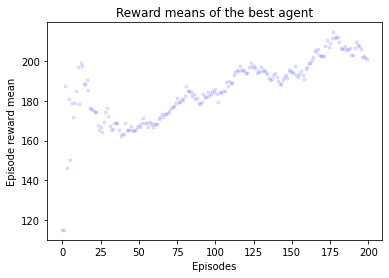

In [ ]:
import matplotlib.pyplot as plt
plt.plot(avg_rewards, 'b.', alpha=.1)
plt.xlabel("Episodes")
plt.ylabel("Episode reward mean")
plt.title("Reward means of the best agent")
plt.show()